# Demo - Gaussianization Flow

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial


KEY = jax.random.PRNGKey(seed=123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [32]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# %%wandb
# get data
seed = 123
n_samples = 5_000
noise = 0.05


def f(n_samples: int = 5_000, noise: float = 0.05, seed: int = 123):
    data, _ = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=seed)
    #     data, _ = datasets.make_circles(
    #         n_samples=n_samples, noise=noise, random_state=seed, factor=0.5
    #     )
    return data


data = f(n_samples, noise, seed)

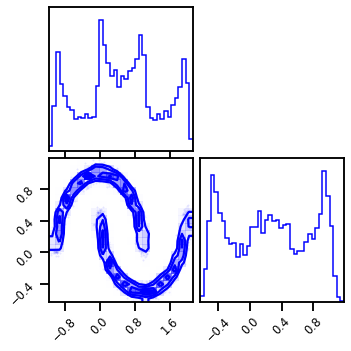

In [33]:
# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)

## Model

In [28]:
from rbig_jax.models.gaussflow import init_default_gf_model

X_init = jnp.array(data, dtype=np.float32)


# marginal uniformization
mixture = "gaussian"
n_components = 12
init_mixcdf = "gmm"

# inverse cdf
inverse_cdf = "gaussian"

# rotation transformation
n_reflections = 2
init_rotation = "random"

# nn params
n_blocks = 10

In [29]:
# init model
gf_model = init_default_gf_model(
    shape=X_init.shape[1:],
    X=X_init,
    n_blocks=n_blocks,
    mixture=mixture,
    n_components=n_components,
    init_mixcdf=init_mixcdf,
    inverse_cdf=inverse_cdf,
    init_rotation=init_rotation,
    n_reflections=n_reflections,
)

Initializing - Block: 10 | Layer 29: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


### Plot Initial Layers

In [30]:
%%time

# X_g = gf_model.forward(X_init)
# X_g, X_ldj = gf_model.forward_and_log_det(X_init)

gf_model.score(X_init)

CPU times: user 1.83 s, sys: 80.8 ms, total: 1.91 s
Wall time: 1.62 s


DeviceArray(1.5672423, dtype=float32)

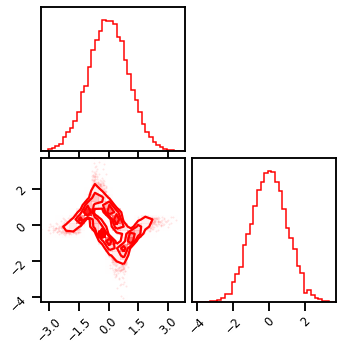

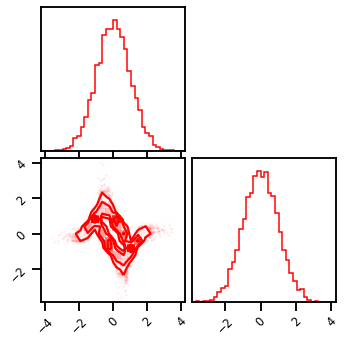

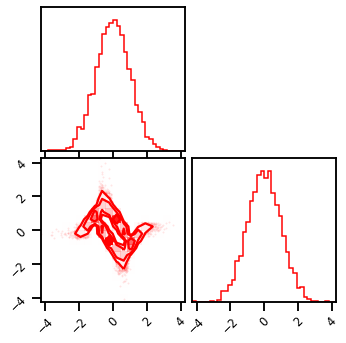

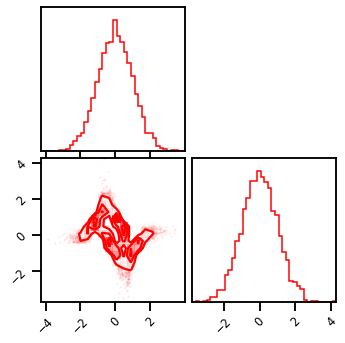

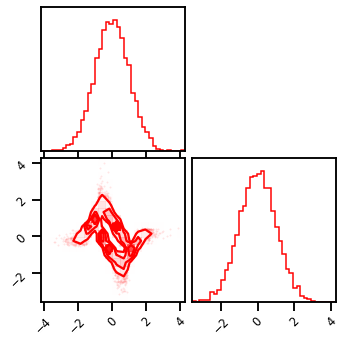

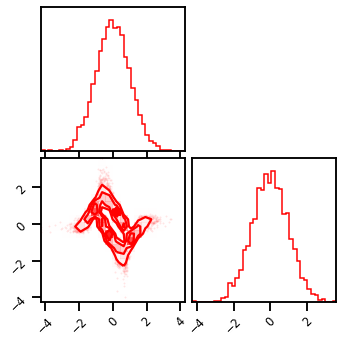

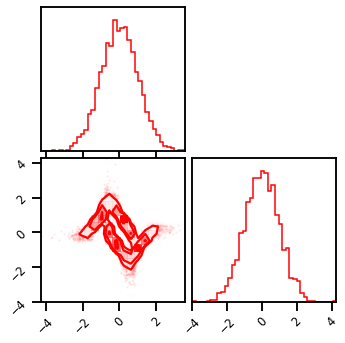

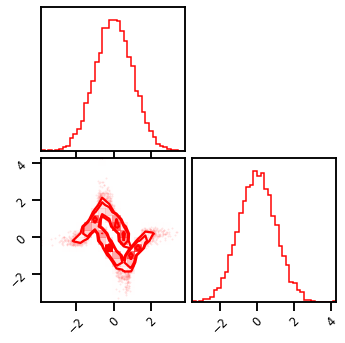

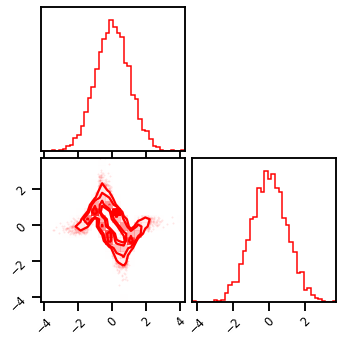

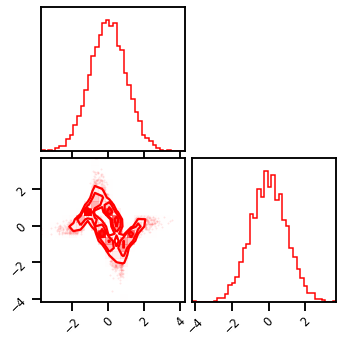

In [31]:
X_g = X_init.copy()

for ibijector in gf_model.bijectors:

    X_g = ibijector.forward(X_g)

    if ibijector.name == "HouseHolder":
        fig = corner.corner(np.array(X_g), color="red", hist_bin_factor=2)

#### Training

## Optimizer

In [34]:
from rbig_jax.training.parametric import init_optimizer

In [35]:
# initialize optimizer
n_epochs = 10_000
optimizer = init_optimizer(
    "adam", lr=1e-3, cosine_decay_steps=n_epochs, gradient_norm_clip=1.0, alpha=1e-2,
)

### Trainer

In [36]:
from rbig_jax.training.parametric import GaussFlowTrainer


# initial flow trainer
nf_trainer = GaussFlowTrainer(gf_model, optimizer, n_epochs=n_epochs)

### DataLoader

In [37]:
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Iterator, Mapping

Batch = Mapping[str, np.ndarray]


def create_dataset(
    batch_size: int,
    n_samples: int = 2_000,
    shuffle: bool = True,
    noise: float = 0.05,
    seed: int = 123,
) -> Iterator[Batch]:
    X = f(n_samples=n_samples, noise=noise, seed=seed)
    ds = tf.data.Dataset.from_tensor_slices((X))
    if shuffle:
        ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

In [39]:
n_train = 5_000
n_test = 1_000
batch_size = 512

ds_train = create_dataset(
    n_samples=n_train, shuffle=True, batch_size=batch_size, seed=123
)
ds_valid = create_dataset(n_samples=n_test, shuffle=False, batch_size=n_test, seed=42)

### Train Model

In [40]:
eval_loss = 0.0
eval_frequency = 50

with tqdm.trange(n_epochs) as pbar:
    for step in pbar:

        # Train Step
        output = nf_trainer.train_step(next(ds_train))
        train_loss = output.loss
        pbar.set_description(
            f"Train Loss: {train_loss:.4f} | Valid Loss: {eval_loss:.4f}"
        )

        # Eval Step
        if step % eval_frequency == 0:
            output = nf_trainer.validation_step(next(ds_valid))
            eval_loss = output.loss
            pbar.set_description(
                f"Train Loss: {train_loss:.4f} | Valid Loss: {eval_loss:.4f}"
            )

gf_model = output.model

Train Loss: 0.2640 | Valid Loss: 0.3220: 100%|██████████| 10000/10000 [04:11<00:00, 39.70it/s]


## Results

### Final Score

In [55]:
nll_score = gf_model.score(X_init)
print(f"NLL Score: {nll_score:.4f}")

NLL Score: 0.2927


#### Losses

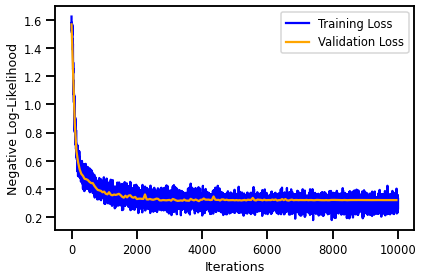

In [41]:
fig, ax = plt.subplots()
ax.plot(
    nf_trainer.train_epoch, nf_trainer.train_loss, label="Training Loss", color="blue"
)
ax.plot(
    nf_trainer.valid_epoch,
    nf_trainer.valid_loss,
    label="Validation Loss",
    color="orange",
)
ax.set(
    xlabel="Iterations", ylabel="Negative Log-Likelihood",
)
plt.legend()
plt.tight_layout()
plt.show()

#### Latent Space

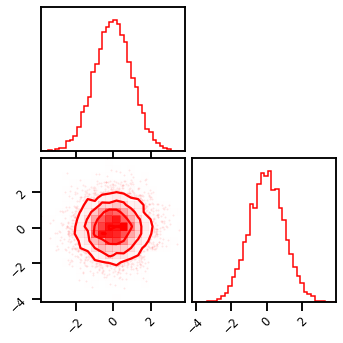

CPU times: user 1.83 s, sys: 88.9 ms, total: 1.92 s
Wall time: 1.58 s


In [42]:
%%time

X_trans = gf_model.forward(X_init)

fig = corner.corner(np.array(X_trans), color="Red", hist_bin_factor=2)
plt.show()

#### Inverse Transform

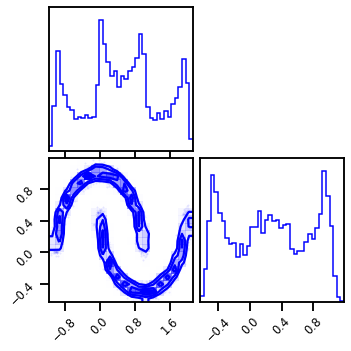

CPU times: user 2min 7s, sys: 10.3 s, total: 2min 18s
Wall time: 36.4 s


In [43]:
%%time

X_approx = gf_model.inverse(X_trans)

fig = corner.corner(np.array(X_approx), color="Blue", hist_bin_factor=2)
plt.show()

### Log Probability

#### Plot: Original Density

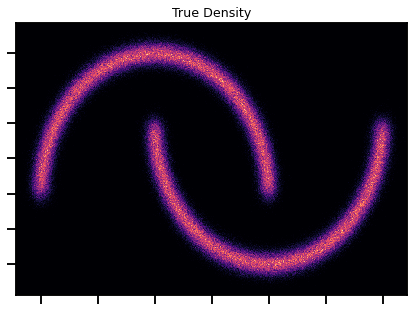

In [45]:
from matplotlib import cm

cmap = cm.magma
# Original Density
n_samples = 1_000_000
noise = 0.05
seed = 42
X_plot = f(n_samples=n_samples, noise=noise, seed=seed)


fig, ax = plt.subplots(figsize=(7, 5))
h = ax.hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True,  # vmin=0.0, vmax=1.0
)
ax.set_title("True Density")
ax.set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
plt.show()

In [46]:
%%time

n_grid = 500
buffer = 0.01
xline = jnp.linspace(X_init[:, 0].min() - buffer, X_init[:, 0].max() + buffer, n_grid)
yline = jnp.linspace(X_init[:, 1].min() - buffer, X_init[:, 1].max() + buffer, n_grid)
xgrid, ygrid = jnp.meshgrid(xline, yline)
xyinput = jnp.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)


# calculate log probability
X_log_prob = gf_model.score_samples(xyinput)

CPU times: user 12.6 s, sys: 3.8 s, total: 16.4 s
Wall time: 3.8 s


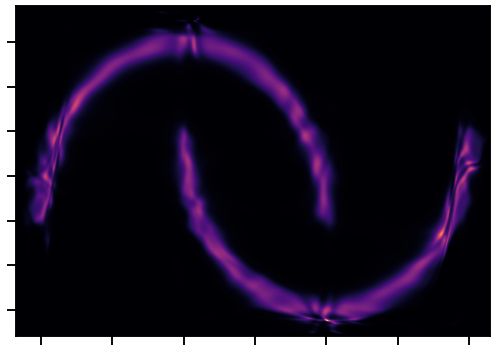

In [47]:
# # Original Density
# n_samples = 1_000_000
# ds_plot = PlaneDataset(n_samples=n_samples, noise=noise, seed=seed)
# X_plot = ds_plot[:]

# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"

fig, ax = plt.subplots(figsize=(7, 5))

h1 = ax.scatter(
    xyinput[:, 0],
    xyinput[:, 1],
    s=1,
    c=probs,
    cmap=cmap,
    #     vmax=0.01,  # vmin=0.0, vmax=1.0
)
ax.set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)


plt.tight_layout()
plt.savefig("demo_jde")
plt.show()

### Sampling

In [48]:
# %%time
# n_gen_samples = 100_000
# pred_batch_size = 10_000
# X_samples = []
# for _ in tqdm.trange(n_gen_samples // pred_batch_size):

#     X_samples.append(final_bijector.sample(seed=123, n_samples=pred_batch_size))

In [49]:
%%time

n_gen_samples = 10_000

X_samples = gf_model.sample(seed=123, n_samples=n_gen_samples)

CPU times: user 3min 23s, sys: 11 s, total: 3min 34s
Wall time: 36.8 s


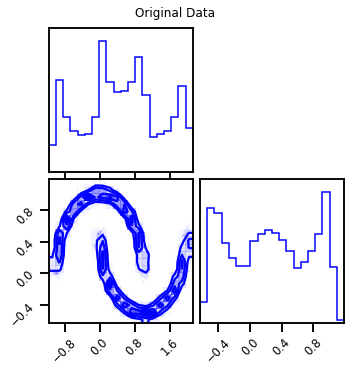

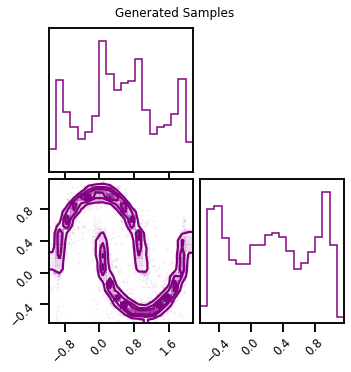

In [50]:
fig = corner.corner(np.array(X_init), color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(np.array(X_samples), color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Each Layer

#### Trained Model

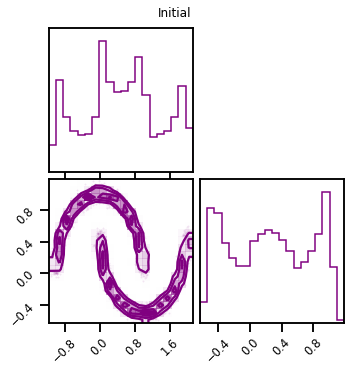

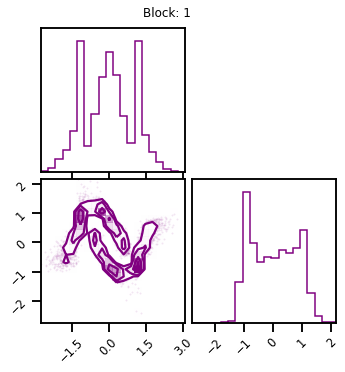

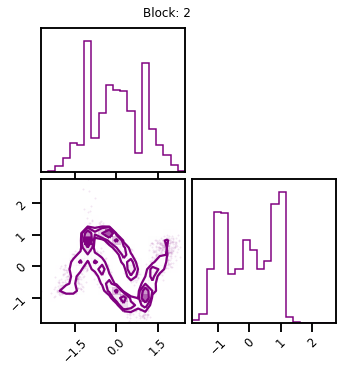

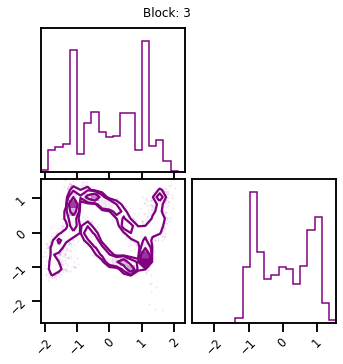

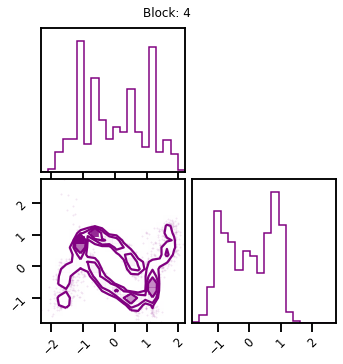

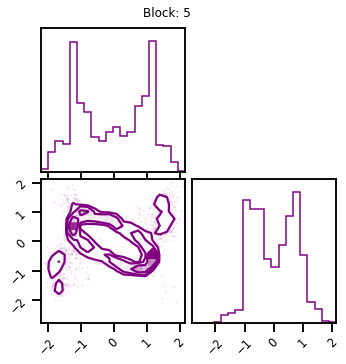

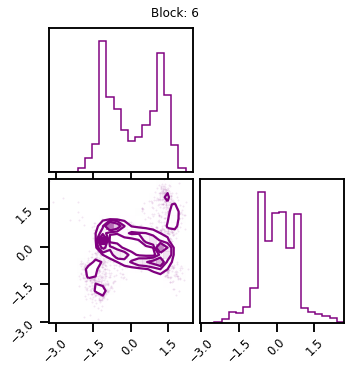

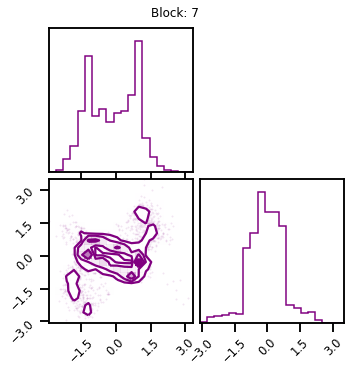

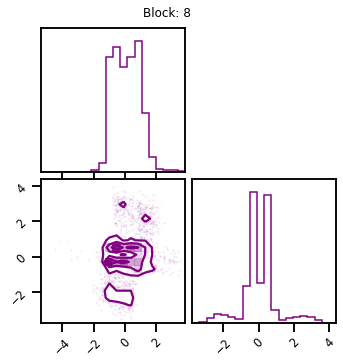

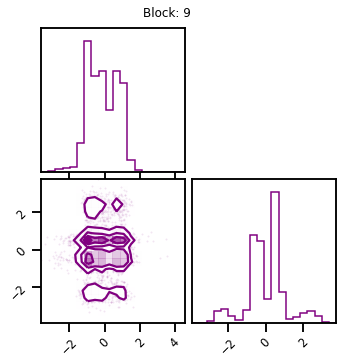

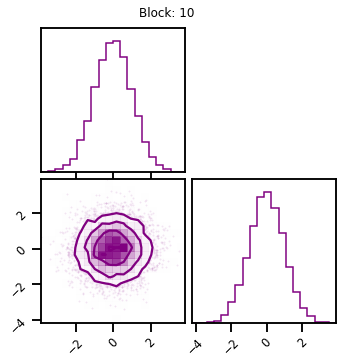

In [51]:
X_g = X_init.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")

plt.show()

for ilayer, ibijector in enumerate(gf_model.bijectors):

    X_g = ibijector.forward(X_g)

    if ibijector.name == "HouseHolder":
        fig = corner.corner(np.array(X_g), color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()

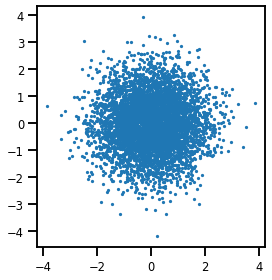

In [52]:
fig, ax = plt.subplots()
ax.scatter(X_g[:, 0], X_g[:, 1], s=3)
ax.set_aspect("equal", "box")
plt.tight_layout()

## Saving/Loading Model

#### Save Model

In [53]:
import joblib

joblib.dump(gf_model, "gf_model.pickle")

['gf_model.pickle']

#### Load Model

In [54]:
rbig_model_loaded = joblib.load("gf_model.pickle")